# Mini Project: Parallel computing in Julia
Anaïs Payard, Joshua Icard

## Problem visualization

In [1]:
# import Pkg; Pkg.add("MAT")
# import Pkg; Pkg.add("Images")

In [35]:
# using Pkg
# Pkg.add("Images")
# Pkg.add("MAT")

using MAT
using Plots
using Images


pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

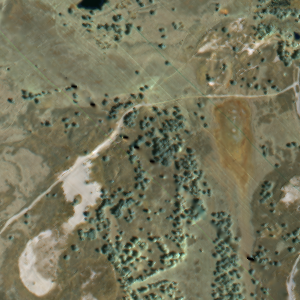

In [57]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
img_rgb = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

# We use display so julia doesn't create xml images which would blow up the file size
display("image/png", img_rgb)

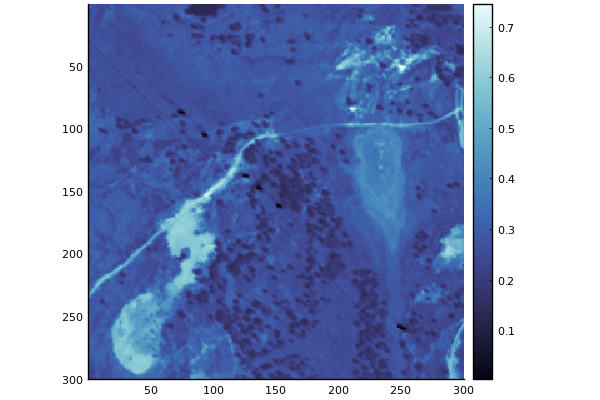

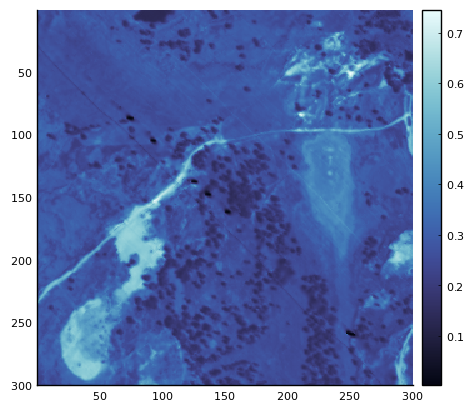

In [59]:
#visualize a spectral band on its own
band = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

# We use display so julia doesn't create xml images which would blow up the file size
display("image/png", band)

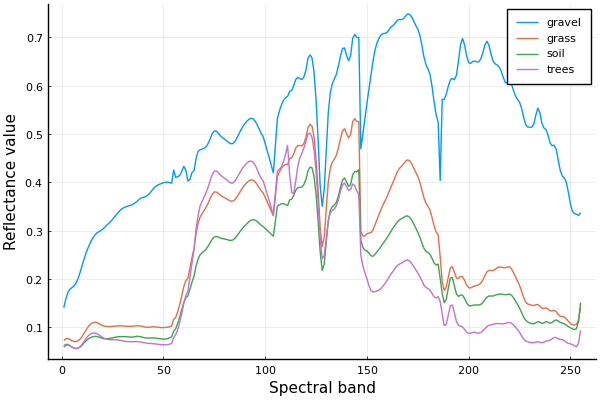

In [38]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

## Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [39]:
# img_small = img[1:100,1:100,:]; # use a small crop of the image first
img_small = copy(img);

# file = matopen("endmembers_houston.mat")
# S = read(file, "S0")
# close(file)

S = sources

255×4 Matrix{Float64}:
 0.140573  0.0729046  0.0615242  0.0586843
 0.158488  0.0760527  0.0643978  0.062294
 0.171616  0.076714   0.0646464  0.0633683
 0.178735  0.0747669  0.0622242  0.0617023
 0.182148  0.0720109  0.0589983  0.0589145
 0.185337  0.0702141  0.0566283  0.0566373
 0.191106  0.0701555  0.0558101  0.0557707
 0.200659  0.0719321  0.0566624  0.0566585
 0.213372  0.0755275  0.0590986  0.0594181
 0.227553  0.0809532  0.0629096  0.0641206
 0.241597  0.0878603  0.0675866  0.0704353
 0.254347  0.0951185  0.0721864  0.0770832
 0.265181  0.101277   0.0758123  0.082386
 ⋮                               
 0.447272  0.126563   0.112988   0.0762418
 0.42492   0.122801   0.110153   0.0747841
 0.412983  0.122072   0.10854    0.0742898
 0.409144  0.120942   0.107088   0.0723655
 0.4002    0.117284   0.104375   0.0690625
 0.379494  0.112302   0.101239   0.0665919
 0.355365  0.107839   0.0988444  0.0655163
 0.339807  0.104961   0.096655   0.0641077
 0.335376  0.104327   0.0949993  0.0614907

## Serial version

### Projected Gradient Descent (applied independently to each pixel)

To estimate the abundances, we use Projected Gradient Descent, applied independently to each pixel.

For a given pixel 𝑛, we solve: 

$$
\underset{\mathbf{a}_n \in \Delta_P}{\min}
\;\frac{1}{2}\left\lVert \mathbf{x}_n - \mathbf{S}\mathbf{a}_n \right\rVert_2^2
$$

Where $\Delta_P$ is the unit simplex: 

$$
\quad
\Delta_P = \left\{ \mathbf{a} \in \mathbb{R}^P \mid \mathbf{a} \ge 0,\;
\mathbf{1}^\top \mathbf{a} = 1 \right\}
$$

The abundance constraints are enforced through a projection step onto the unit simplex after each gradient descent update. This projection guarantees both the non-negativity and the sum-to-one constraints on the abundance coefficients.

In [40]:
# Reshaping so that the image X ∈ ℝ^{L×N}
H, W, L = size(img_small)
X = reshape(img_small, H*W, L)' 

255×90000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0648938  0.0617573  0.0609308  …  0.0485119  0.0611851  0.0623083
 0.068173   0.0658425  0.0648759     0.0539349  0.0643627  0.0651272
 0.0690389  0.0674935  0.0663286     0.0567108  0.0649501  0.065559
 0.0673836  0.0664697  0.0651544     0.05663    0.0630262  0.0636192
 0.0648676  0.0643107  0.063004      0.0552882  0.060445   0.0609725
 0.0630381  0.0626672  0.0614387  …  0.0541779  0.0586767  0.05904
 0.062654   0.0624742  0.0612281     0.0540753  0.0582237  0.0584499
 0.0640878  0.0640626  0.0626603     0.0552975  0.0590767  0.0593052
 0.067621   0.0676078  0.0659021     0.0578231  0.0611271  0.0614523
 0.0733457  0.0733016  0.0710652     0.0613864  0.0642358  0.0646534
 0.0807916  0.0808287  0.0778054  …  0.0655769  0.068027   0.0684863
 0.0886246  0.0888034  0.0848606     0.0697214  0.0717923  0.072196
 0.0952251  0.0954543  0.0906644     0.0730669  0.0748146  0.0750805
 ⋮                                ⋱              

In [41]:
# Simplex projection
function project_simplex(v)
    u = sort(v, rev=true)
    cssv = cumsum(u)
    rho = findlast(i -> u[i] > (cssv[i] - 1) / i, 1:length(u))
    theta = (cssv[rho] - 1) / rho
    return max.(v .- theta, 0)
end

# Abundance estimation for one pixel
function unmix_pixel(x, S; μ=1e-2, K=100)
    # We use the algorithm proposed by Duchi et al. (2008) to project a vector 𝑣 ∈ ℝ^{P} onto the simplex.
    P = size(S, 2)
    a = fill(1/P, P)

    for k in 1:K
        grad = S' * (S * a - x)
        a -= μ * grad
        a = project_simplex(a)
    end
    return a
end

# Unmixing function
function unmix_serial(X, S)
    N = size(X, 2)
    P = size(S, 2)
    A = zeros(P, N)

    for n in 1:N
        A[:, n] = unmix_pixel(X[:, n], S)
    end
    return A
end

unmix_serial (generic function with 1 method)

In [42]:
A = unmix_serial(X, S)

4×90000 Matrix{Float64}:
 0.0940382  0.106012   0.0981444  0.0247042  …  0.0       0.0       0.0
 0.426611   0.438602   0.433766   0.37274       0.163575  0.204848  0.210205
 0.0608597  0.0622878  0.141801   0.321913      0.63258   0.652276  0.64464
 0.418491   0.393098   0.326289   0.280643      0.203846  0.142876  0.145155

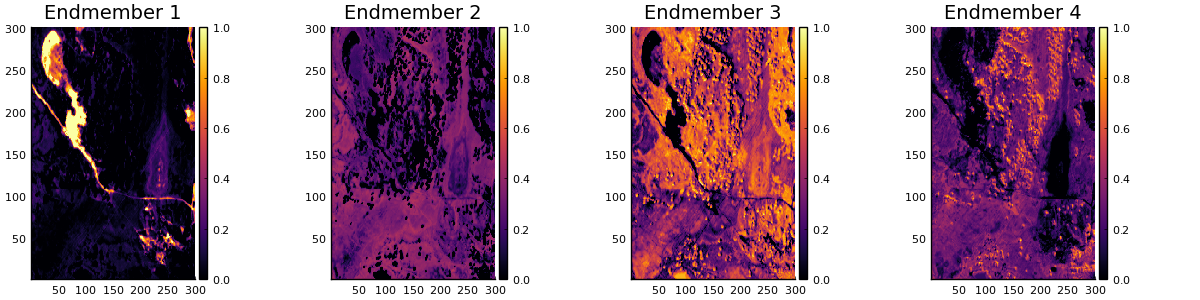

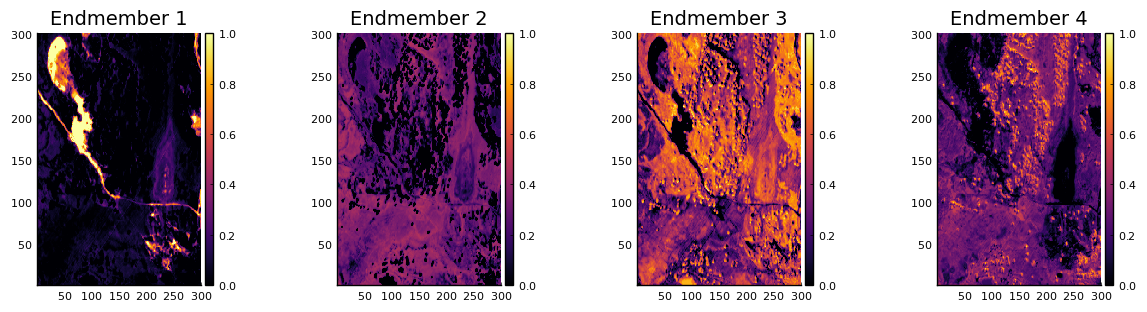

In [66]:
# Show the results

# Reshaping abundance
P = size(S, 2)
abundance_maps = [reshape(A[p, :], H, W) for p in 1:P]

# Showing all maps side by side
p1 = plot([heatmap(abundance_maps[p], clims=(0,1), title="Endmember $p") for p in 1:P]...,layout=(1,P), size=(300*P,300));

# We use display so julia doesn't create xml images which would blow up the file size
display("image/png", p1)

### Projected Gradient Descent (at the image level)

Instead of estimating the abundances independently for each pixel, the abundance estimation problem can be formulated directly at the image level.

Given the linear mixing model:

$$
X=SA+E
$$

the global optimization problem is:

$$
\underset{\mathbf{A} \in \mathbf{ℝ}^{P×N}}{\min}
\;\frac{1}{2}\left\lVert \mathbf{X} - \mathbf{S}\mathbf{A} \right\rVert_F^2 \quad \text{subject to} \quad
\forall n,\;\mathbf{a}_n \in \Delta_P
$$

where each column  $\mathbf{a}_n$ of the abundance matrix 𝐴 belongs to the unit simplex $\Delta_P$, enforcing both the non-negativity and sum-to-one constraints.

In [44]:
# Initialisation of A
P = size(S, 2)
N = size(X, 2)
A = fill(1/P, P, N)     # each column sum at 1

4×90000 Matrix{Float64}:
 0.25  0.25  0.25  0.25  0.25  0.25  …  0.25  0.25  0.25  0.25  0.25  0.25
 0.25  0.25  0.25  0.25  0.25  0.25     0.25  0.25  0.25  0.25  0.25  0.25
 0.25  0.25  0.25  0.25  0.25  0.25     0.25  0.25  0.25  0.25  0.25  0.25
 0.25  0.25  0.25  0.25  0.25  0.25     0.25  0.25  0.25  0.25  0.25  0.25

In [45]:
# Unmixing function
function unmix_global(X, S; μ=1e-2, K=100)
    P = size(S, 2)
    N = size(X, 2)

    A = fill(1/P, P, N)

    for k in 1:K
        grad = S' * (S * A - X)   # global gradient 
        A .-= μ .* grad          # gradient descent 

        # column by column projection
        for n in 1:N
            A[:, n] = project_simplex(A[:, n])
        end
    end

    return A
end

unmix_global (generic function with 1 method)

In [46]:
A = unmix_global(X, S)

4×90000 Matrix{Float64}:
 0.0940382  0.106012   0.0981444  0.0247042  …  0.0       0.0       0.0
 0.426611   0.438602   0.433766   0.37274       0.163575  0.204848  0.210205
 0.0608597  0.0622878  0.141801   0.321913      0.63258   0.652276  0.64464
 0.418491   0.393098   0.326289   0.280643      0.203846  0.142876  0.145155

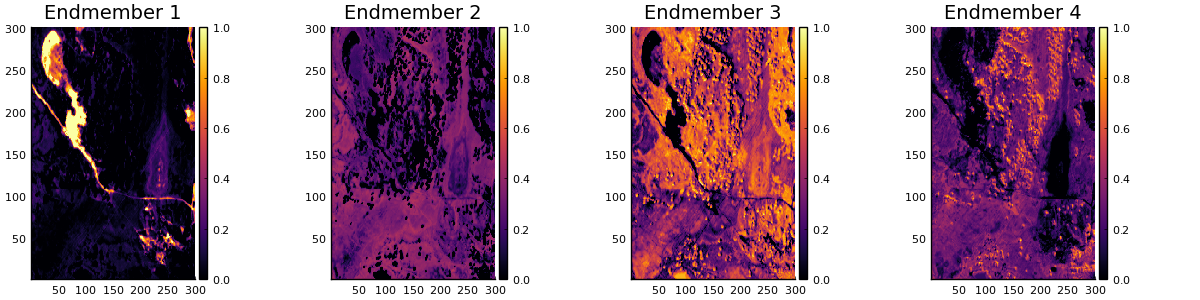

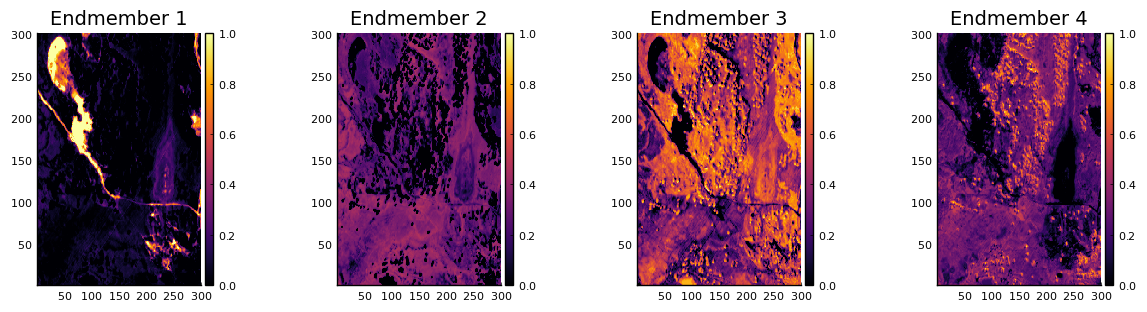

In [65]:
# Show the results

# Reshaping abundance
P = size(S, 2)
abundance_maps = [reshape(A[p, :], H, W) for p in 1:P]

# Showing all maps side by side
p2 = plot([heatmap(abundance_maps[p], clims=(0,1), title="Endmember $p") for p in 1:P]..., layout=(1,P), size=(300*P,300));

# We use display so julia doesn't create xml images which would blow up the file size
display("image/png", p2)

## Parallelized version using chucking of the image

In [48]:
# Parallel version (Chunking of the image)
using Distributed
using SharedArrays

CPU_CORES = 4 # number of cores on the machine

addprocs(CPU_CORES - 1) # add workers

# Add necessary packages on all workers
@everywhere using SharedArrays

In [49]:
# Add necessary functions on all workers
@everywhere function myrange(q::SharedMatrix, split_dim::Int)
    idx = indexpids(q)
    base_range = [1:size(q, dim) for dim in 1:ndims(q)]

    if idx == 0 # This worker is not assigned a piece
        return 1:0, 1:0
    end
    nchunks = length(procs(q))
    splits = [round(Int, s) for s in range(0, stop=size(q, split_dim), length=nchunks+1)]
    
    base_range[split_dim] = (splits[idx] + 1):splits[idx + 1]
    return base_range
end

# Simplex projection
@everywhere function project_simplex(v)
    u = sort(v, rev=true)
    cssv = cumsum(u)
    rho = findlast(i -> u[i] > (cssv[i] - 1) / i, 1:length(u))
    theta = (cssv[rho] - 1) / rho
    return max.(v .- theta, 0)
end

# Abundance estimation for one pixel
@everywhere function unmix_pixel(x, S; μ=1e-2, K=100)
    # We use the algorithm proposed by Duchi et al. (2008) to project a vector 𝑣 ∈ ℝ^{P} onto the simplex.
    P = size(S, 2)
    a = fill(1/P, P)

    for k in 1:K
        grad = S' * (S * a - x)
        a -= μ * grad
        a = project_simplex(a)
    end
    return a
end

@everywhere function unmix_parallel_chunk(X::SharedMatrix, A::SharedMatrix, S::SharedMatrix)
    r1, r2 = myrange(A, 2)

    for n in r2
        A[:, n] = unmix_pixel(X[:, n], S)
    end
    A
end

function unmix_shared!(X::SharedMatrix,A::SharedMatrix,S::SharedMatrix)
    @sync begin
        for p in procs(A)
            Threads.@spawn remotecall_wait(unmix_parallel_chunk, p, X, A, S)
        end
    end
    A
end

unmix_shared! (generic function with 1 method)

In [50]:
# Prepare the data for parallel processing
X_shared = SharedArray{Float64}(size(X))
X_shared[:] = X[:]

S_shared = SharedArray{Float64}(size(S))
S_shared[:] = S[:]

P = size(S, 2)
N = size(X, 2)
A_parallel = SharedArray{Float64}((P, N))

4×90000 SharedMatrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [51]:
A_para_chunk = unmix_shared!(X_shared, A_parallel, S_shared)

4×90000 SharedMatrix{Float64}:
 0.0940382  0.106012   0.0981444  0.0247042  …  0.0       0.0       0.0
 0.426611   0.438602   0.433766   0.37274       0.163575  0.204848  0.210205
 0.0608597  0.0622878  0.141801   0.321913      0.63258   0.652276  0.64464
 0.418491   0.393098   0.326289   0.280643      0.203846  0.142876  0.145155

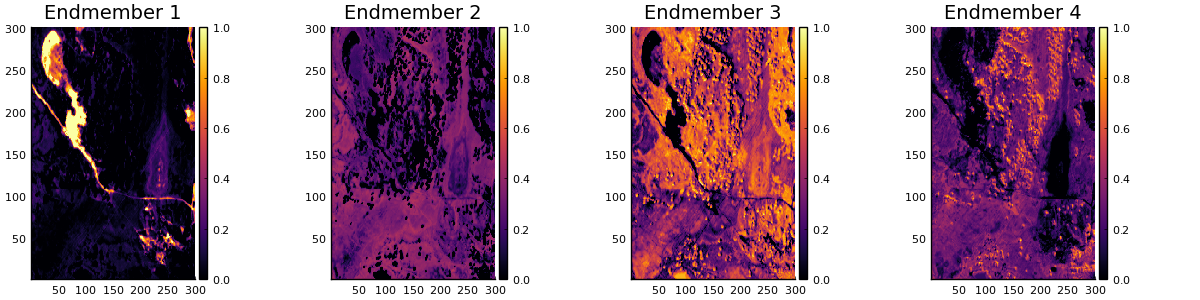

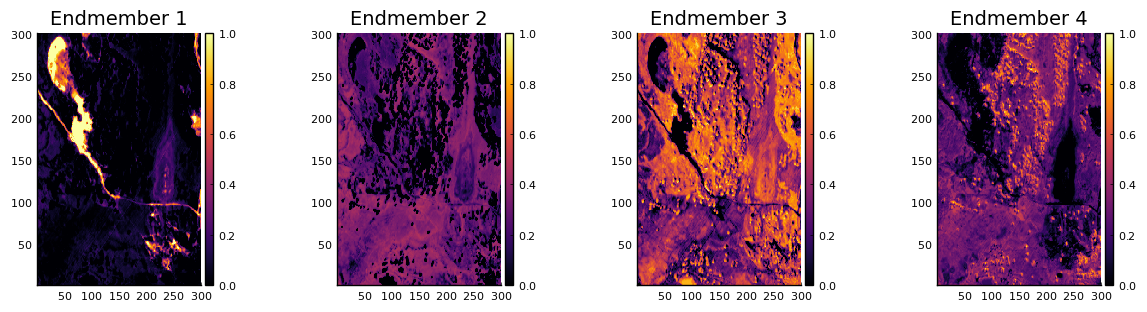

In [64]:
# Show the results

# Reshaping abundance
P = size(S, 2)
abundance_maps = [reshape(A[p, :], H, W) for p in 1:P]

# Showing all maps side by side
p3 = plot([heatmap(abundance_maps[p], clims=(0,1), title="Endmember $p") for p in 1:P]...,layout=(1,P), size=(300*P,300));

# We use display so julia doesn't create xml images which would blow up the file size
display("image/png", p3)

# Comparing the speed of the different implementations

Here we compare the speed of the different implementation that we did to see if we gain time with the parallelisation

## Serial Versions

In [53]:
@time unmix_serial(X, S)

 18.860246 seconds (162.61 M allocations: 40.952 GiB, 32.78% gc time, 0.68% compilation time: 100% of which was recompilation)


4×90000 Matrix{Float64}:
 0.0940382  0.106012   0.0981444  0.0247042  …  0.0       0.0       0.0
 0.426611   0.438602   0.433766   0.37274       0.163575  0.204848  0.210205
 0.0608597  0.0622878  0.141801   0.321913      0.63258   0.652276  0.64464
 0.418491   0.393098   0.326289   0.280643      0.203846  0.142876  0.145155

In [54]:
@time unmix_global(X, S)

 23.518441 seconds (72.04 M allocations: 37.690 GiB, 33.84% gc time, 0.51% compilation time: 100% of which was recompilation)


4×90000 Matrix{Float64}:
 0.0940382  0.106012   0.0981444  0.0247042  …  0.0       0.0       0.0
 0.426611   0.438602   0.433766   0.37274       0.163575  0.204848  0.210205
 0.0608597  0.0622878  0.141801   0.321913      0.63258   0.652276  0.64464
 0.418491   0.393098   0.326289   0.280643      0.203846  0.142876  0.145155

## Parallel Versions

In [55]:
A_parallel = SharedArray{Float64}((P, N))

4×90000 SharedMatrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [56]:
@time unmix_shared!(X_shared, A_parallel, S_shared)

  6.040603 seconds (1.37 k allocations: 90.781 KiB)


4×90000 SharedMatrix{Float64}:
 0.0940382  0.106012   0.0981444  0.0247042  …  0.0       0.0       0.0
 0.426611   0.438602   0.433766   0.37274       0.163575  0.204848  0.210205
 0.0608597  0.0622878  0.141801   0.321913      0.63258   0.652276  0.64464
 0.418491   0.393098   0.326289   0.280643      0.203846  0.142876  0.145155

## Conclucion

We implemented a hyperspectral unmixing algorithm based on projected gradient descent, enforcing both the non-negativity and sum-to-one constraints on the abundances. Thanks to the pixel-wise separability of the optimization problem, the algorithm is naturally parallelizable. Experimental results demonstrate a clear computational gain when using the parallel implementation compared to the serial version.